In [57]:
##  CICIDS2017 csv files are required for the operation of the program.
##  These files must be located under the "CSVs" folder in the same directory as the program.



##  The purpose of this program is to clear the csv files containing CICIDS2017 data from errors.
##  the faults observed are:
##      1-   288602 of the entries in the file "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv" are empty / meaningless.
##                   (e.g. ",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,")
##
##      2-  In the original csv files, while describing the Web Attack types such as Brute Force, XSS, Sql Injection, the character used is not recognized
##                    by the Python-Pandas library and leads to the error.
##                    this character ("–", Unicode code:8211) has been changed with another character ("-", Unicode code:45) to correct the error.
##
##   After the error correction, all the csv files were made into a single file (all_date.csv) to make it easier to process.

import pandas as pd
import os
from sklearn import preprocessing
import time
seconds = time.time()
%matplotlib inline

print("This process may take 1 to 2 minutes, depending on the performance of your computer.\n\n\n")
number="0123456789"
# CSV files names:
csv_files=["Train_Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX"] # I Removed all other attacks files

# Headers of column
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","faulty-Fwd Header Length","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]

main_labels2=main_labels # Backup
main_labels=( ",".join( i for i in main_labels ) )  # Convert main_labels array into single string
main_labels=main_labels+"\n"
flag=True
for i in range(len(csv_files)):
    ths = open(str(i)+".csv", "w")
    ths.write(main_labels)
    with open("./CSVs/"+csv_files[i]+".csv", "r") as file:
        while True:
            try:
                line=file.readline()
                if  line[0] in number:# this line eliminates the headers of CSV files and incomplete streams .
                    if " – " in str(line): ##  if there is "–" character ("–", Unicode code:8211) in the flow ,  it will be changed with "-" character ( Unicode code:45).
                        line=(str(line).replace(" – "," - "))
                    line=(str(line).replace("inf","0"))
                    line=(str(line).replace("Infinity","0"))
                    line=(str(line).replace("NaN","0"))
                     
                    ths.write(str(line))
                else:
                    continue                       
            except:
                break
    ths.close()
 
 
    df=pd.read_csv(str(i)+".csv",low_memory=False) # load large csv into ram in one go.
    df=df.fillna(0) # replaces all missing or NaN values in df with the value 0. 

    string_features=["Flow Bytes/s","Flow Packets/s"]
    for ii in string_features: #Some data in the "Flow Bytes / s" and "Flow Packets / s" columns are not numeric. Fixing this bug in this loop
        df[ii]=df[ii].replace('Infinity', -1)
        df[ii]=df[ii].replace('NaN', 0)
        number_or_not=[]
        for iii in df[ii]:
            try:                      # If it can be converted into int then convert it and append , else append original
                k=int(float(iii))
                number_or_not.append(int(k))
            except:
                number_or_not.append(iii)
        df[ii]=number_or_not



    string_features=[]
    for j in main_labels2: # In this section, non-numeric (string and / or categorical) properties (columns) are detected.
        if df[j].dtype=="object":
            string_features.append(j)
    try:
        string_features.remove('Label')#The "Label" property was removed from the list. Because it has to remain "categorical" for using with different machine learning approach.
    except:
        print("error!")
    labelencoder_X = preprocessing.LabelEncoder() 
    #LabelEncoder() class is being used to transform categorical values into numerical values.


    for ii in string_features: ## In this loop, non-numeric (string and/or categorical) properties converted to numeric features.
        try:
            df[ii]=labelencoder_X.fit_transform(df[ii])
        except:
            df[ii]=df[ii].replace('Infinity', -1)
    df=df.drop(main_labels2[61], axis=1) ## Column 61 is deleted because it is unnecessary, column 41 ("Fwd Header Length" feature) had be mistakenly rewritten.



#     For Training
#     if flag:
#         df.to_csv('portScan.csv' ,index = False)
#         flag=False
#     else:
#         df.to_csv('portScan.csv' ,index = False,header=False,mode="a")

# For Testing
    if flag:
        df.to_csv('portScan_train.csv' ,index = False)
        flag=False
    else:
        df.to_csv('portScan_train.csv' ,index = False,header=False,mode="a")
    os.remove(str(i)+".csv")
    print("The pre-processing phase of the ",csv_files[i]," file is completed.\n")
    
    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")
    

This process may take 1 to 2 minutes, depending on the performance of your computer.



The pre-processing phase of the  Train_Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX  file is completed.

mission accomplished!
Total operation time: =  11.267733573913574 seconds


PortScan    158930
BENIGN      127473
Name: Label, dtype: int64


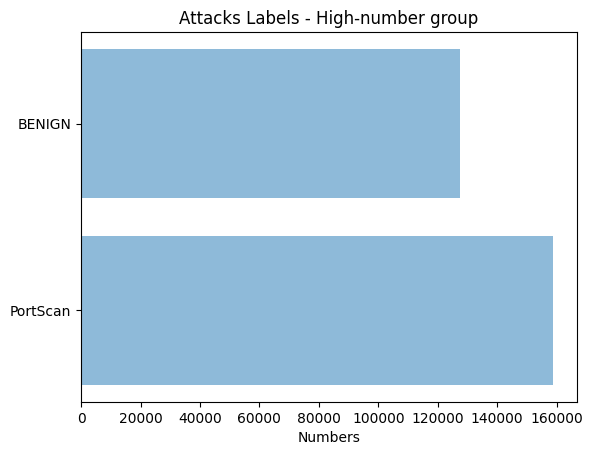

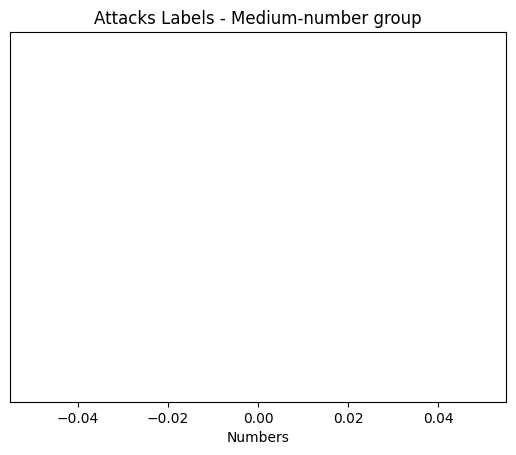

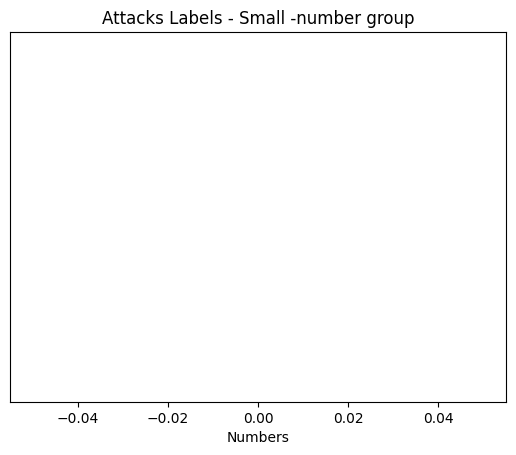

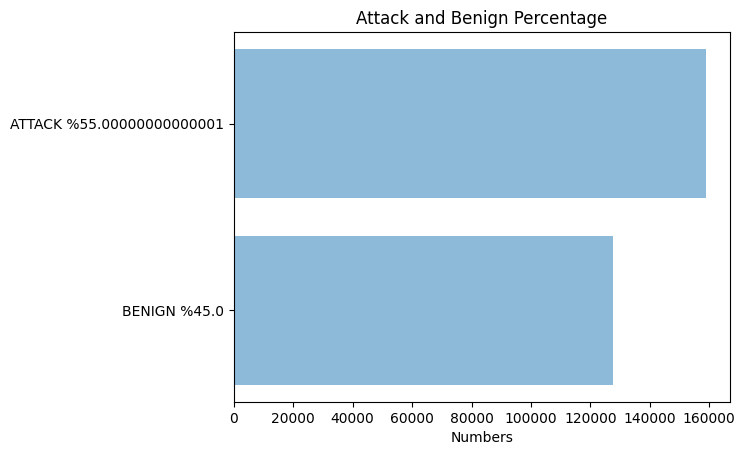

mission accomplished!
Total operation time: =  0.9245994091033936 seconds


In [58]:

##  portScan.csv files is required for the operation of the program.
##  portScan.csv file must be located in the same directory as the program.



##  The purpose of this program is to provide statistics about the data contained in the dataset.
##  Considering that some of the data are very large and some of them are very small, the graphics are created in three separate groups, so that all data can be seen:
##          big: labels with more than 11000 numbers
##          medium: labels with numbers between 600 and 11000
##          small: labels with fewer than 600 numbers
##  
##  In the last graphics, the rates of all attacks and normal behaviors are given.



import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
%matplotlib inline
import time
seconds = time.time()

#  graph creation function
def graph(objects,performance,x_label,y_label):
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()


df=pd.read_csv('portScan_train.csv', usecols=["Label"])  # pd will load only "Label" column data
print(df.iloc[:,0].value_counts())  # print count of all rows 1st column unique value of df
a=(df.iloc[:,0].value_counts())



key=a.keys()      # used to extract unique values and store into key array i.e. key[0] have unique label name
values=a.values  #  used to extract frequency of unique values and store into values i.e. value[0] have count of that
small_labels=[]
small_values=[]
big_labels=[]
big_values=[]
medium_labels=[]
medium_values=[]
attacak=0
benign=0


## In this section, the attacks are grouped under 3 groups,
## so that all values can be seen on the graph.
for i in range(0,len(values)):
    if values[i]>11000:
        big_labels.append(str(key[i]))
        big_values.append(values[i])
    elif values[i]<600:
        small_labels.append(str(key[i]))
        small_values.append(values[i]) 
    else:
        medium_labels.append(str(key[i]))
        medium_values.append(values[i])

    if str(key[i])=="BENIGN":
        benign+=values[i]
    else:
        attacak+=values[i]
        
key =[benign,attacak]


#functions are called to create a chartes
labels=["BENIGN %"+str(round(benign/(benign+attacak),2)*100), # benign percentage till 2 decimal places
        "ATTACK %"+str(round(attacak/(benign+attacak),2)*100)] # attack percentage
graph(big_labels,big_values,"Numbers","Attacks Labels - High-number group")
graph(medium_labels,medium_values,"Numbers","Attacks Labels - Medium-number group")
graph(small_labels,small_values,"Numbers","Attacks Labels - Small -number group")
graph(labels,key,"Numbers","Attack and Benign Percentage")



print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")


# BENIGN                        2359289
# DoS Hulk                       231073
# PortScan                       158930
# DDoS                            41835
# DoS GoldenEye                   10293
# FTP-Patator                      7938
# SSH-Patator                      5897
# DoS slowloris                    5796
# DoS Slowhttptest                 5499
# Bot                              1966
# Web Attack - Brute Force         1507
# Web Attack - XSS                  652
# Infiltration                       36
# Web Attack - Sql Injection         21
# Heartbleed                         11
# Name: Label, dtype: int64




portScan importance list:
portScan 
                              importance
Features                               
Fwd Packet Length Max          0.305881
Total Length of Fwd Packets    0.238678
Flow Bytes/s                   0.136947
Flow IAT Mean                  0.000899
Bwd Packet Length Min          0.000386
Flow IAT Min                   0.000385
Fwd Packet Length Mean         0.000261
Flow Packets/s                 0.000230
Flow IAT Std                   0.000161
Bwd Packet Length Std          0.000161
Flow IAT Max                   0.000147
Fwd IAT Total                  0.000124
Flow Duration                  0.000090
Bwd Packet Length Max          0.000039
Fwd Packet Length Std          0.000031
Fwd Packet Length Min          0.000023
Bwd Packet Length Mean         0.000015
Total Backward Packets         0.000015
Total Fwd Packets              0.000014
Total Length of Bwd Packets    0.000006 



portScan=["Fwd Packet Length Max","Total Length of Fwd Packets","Flow Bytes/s",

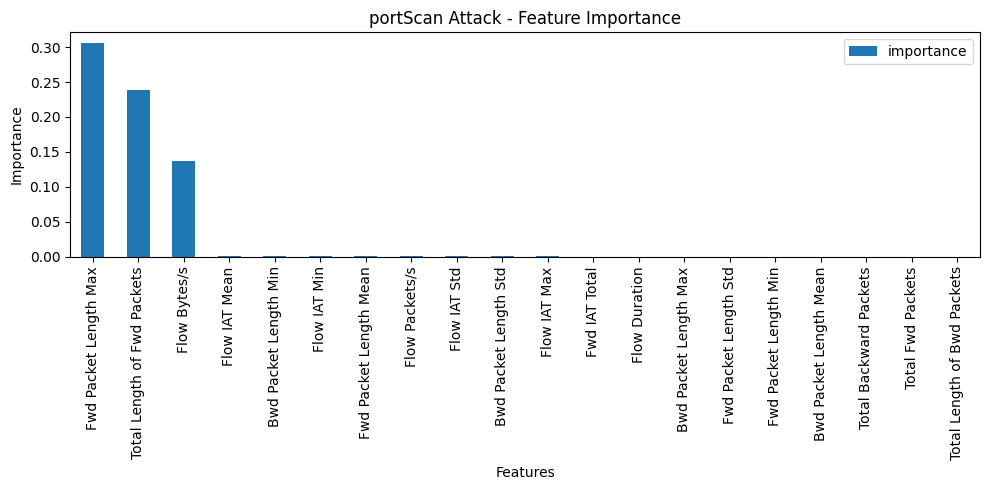

In [40]:
##  "portScan.csv" file is required for the operation of the program.
##  "portScan.csv" file must be located in the same directory as the program.


##  the purpose of this code is to determine which features to use in the machine learning phase.
##  for this purpose, the importance weights of the attacks are calculated.
##  this calculation was made using sklearn-RandomForestRegressor.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time
seconds = time.time()

def folder(f_name): #this function creates a folder named "feaure_pics" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        
# CSV files names:
csv_files=["portScan.csv"]# It creates a list of file names in the "attacks" folder.

# Headers of column
main_labels=["Flow Duration","Total Fwd Packets",   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

ths = open("importance_list_portScan.csv", "w")
folder("./feaure_pics/")
for j in csv_files:
    df=pd.read_csv(j,usecols=main_labels)
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    X = df.values
   
   
    X = np.float32(X)
    X[np.isnan(X)] = 0
    X[np.isinf(X)] = 0
    
    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+" Attack - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', orientation = 'portrait', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    #plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"secomds")
ths.close()
    

In [ ]:
# This code appears to be using scikit-learn's RandomForestRegressor to train a regression model on data represented by the feature matrix X and target values y. It then calculates and visualizes the feature importances using matplotlib. The top 20 features with the highest importances are plotted in a bar chart, and the chart is saved as a PDF file. The feature importances are also printed out, and a string representation of the top 5 features is created and saved to a file.

# Here is a breakdown of the code:

# forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0): Initializes a RandomForestRegressor model with 250 estimators (decision trees) and a random state of 0.

# forest.fit(X, y): Fits the RandomForestRegressor model to the feature matrix X and target values y, training the model.

# importances = forest.feature_importances_: Calculates the feature importances using the trained RandomForestRegressor model.

# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0): Calculates the standard deviation of feature importances across all the decision trees in the forest.

# indices = np.argsort(importances)[::-1]: Sorts the feature importances in descending order and returns the indices of the sorted importances.

# refclasscol=list(df.columns.values): Creates a list of column names from the original dataframe df.

# impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]}): Creates a pandas DataFrame with the top 20 features and their corresponding importances.

# impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features'): Sorts the DataFrame by importance values in descending order and sets the 'Features' column as the index.

# plt.rcParams['figure.figsize'] = (10, 5): Sets the size of the plot figure.

# impor_bars.plot.bar(): Plots the feature importances as a bar chart.

# count=0: Initializes a count variable.

# fea_ture=j[0:-4]+"=[": Initializes a string representation of the top 5 features.

# for i in impor_bars.index: ...: Loops through the top 5 features in the impor_bars DataFrame and adds them to the string representation.

# if count==5: ...: Checks if 5 features have been added to the string representation.

# print(j[0:-4],"importance list:"): Prints the name of the file (without the file extension) and a label for the list of feature importances.

# print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n"): Prints the top 20 features and their importances in the impor_bars DataFrame.

# print(fea_ture): Prints the string representation of the top 5 features.

# plt.title(j[0:-4]+" Attack - Feature Importance"): Sets the title of the plot.

# plt.ylabel('Importance'): Sets the y-axis label of the plot.

# plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', orientation = 'portrait', format = 'pdf'): Saves the plot as a PDF file with a filename based on the original file name.

# ths.write(( fea_ture ) ): Writes the string representation of the top

File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
PortScan          Naive Bayes        0.64            0.78            0.6             0.55            0.1033         
PortScan          QDA                0.9             0.92            0.89            0.9             0.1545         
PortScan          Random Forest      1.0             1.0             1.0             1.0             0.994          
PortScan          ID3                1.0             1.0             1.0             1.0             0.3622         
PortScan          AdaBoost           0.99            0.99            0.99            0.99            5.1507         
PortScan          MLP                0.71            0.83            0.67            0.64            16.4364        
PortScan          Nearest Neighbors  1.0             1.0             1.0             1.0             6.9449         


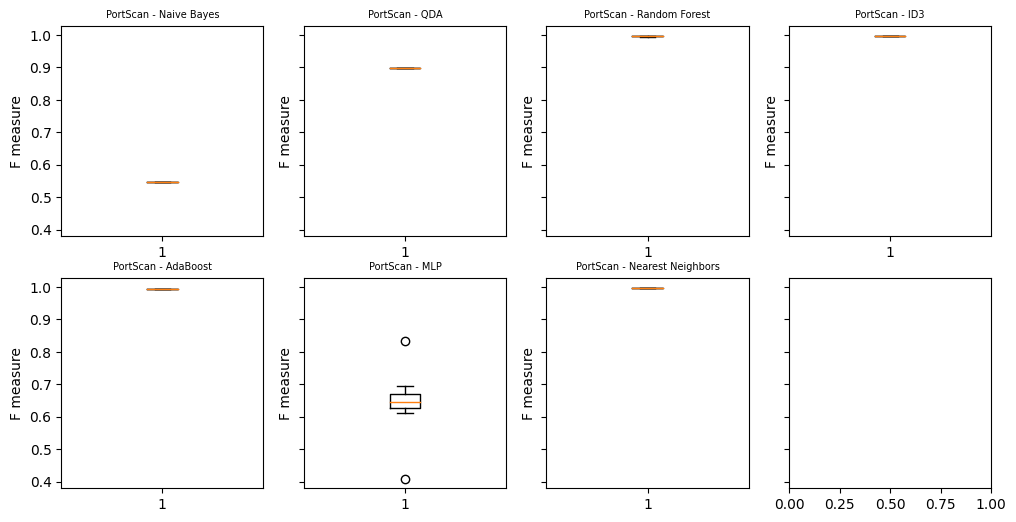


------------------------------------------------------------------------------------------------------


mission accomplished!
Total operation time: =  303.4476034641266 seconds


In [28]:
##  "portScan.csv" file is required for the operation of the program.
##  "portScan.csv" file must be located in the same directory as the program.

##  the purpose of this program is to apply machine learning algorithms to the dataset and observe the performance of algorithms.
##  the algorithms used are:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest Neighbors
##  As the program display output data include: file name, machine learning algorithm name, accuracy,Precision, Recall, F1-score,Time
##  the program will create a CSV file that prints the results and a folder containing graphics.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")

result="./results/results_1.csv" #a CSV file is named in which the results are saved.
csv_files=os.listdir("attacks")# CSV files names: #The names of the files in the attacks folder are taken and assigned to a list (csv_files).
path="./attacks/"
repetition=10  # 10 times each ML algo apply on each file.


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_1/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3)}

# the features to be used for each attack type is defined in a dictionary(features).
# the first 4 of the features created by the file "04_1_feature_selection_for_attack_files.py" are used here.
features={"Bot":["Bwd Packet Length Mean","Flow IAT Max","Flow Duration","Flow IAT Min","Label"],
"DDoS":["Bwd Packet Length Std","Total Backward Packets","Fwd IAT Total","Flow Duration","Label"],
"DoS GoldenEye":["Flow IAT Max","Bwd Packet Length Std","Flow IAT Min","Total Backward Packets","Label"],
"DoS Hulk":["Bwd Packet Length Std","Fwd Packet Length Std","Fwd Packet Length Max","Flow IAT Min","Label"],
"DoS Slowhttptest":["Flow IAT Mean","Fwd Packet Length Min","Bwd Packet Length Mean","Total Length of Bwd Packets","Label"],
"DoS slowloris":["Flow IAT Mean","Total Length of Bwd Packets","Bwd Packet Length Mean","Total Fwd Packets","Label"],
"FTP-Patator":["Fwd Packet Length Max","Fwd Packet Length Std","Fwd Packet Length Mean","Bwd Packet Length Std","Label"],
"Heartbleed":["Total Backward Packets","Fwd Packet Length Max","Flow IAT Min","Bwd Packet Length Max","Label"],
"Infiltration":["Fwd Packet Length Max","Fwd Packet Length Mean","Flow Duration","Total Length of Fwd Packets","Label"],
"PortScan":["Flow Bytes/s","Total Length of Fwd Packets","Fwd IAT Total","Flow Duration","Label"],
"SSH-Patator":["Fwd Packet Length Max","Flow Duration","Flow IAT Max","Total Length of Fwd Packets","Label"],
"Web Attack":["Bwd Packet Length Std","Total Length of Fwd Packets","Flow Bytes/s","Flow IAT Max","Label"]}

seconds=time.time()#time stamp for all processing time



with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header
    a=[]
    
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
                  
            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')

            
            
            
            
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )


        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
        a.append(f1)


     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.

     
    ml=["Naive Bayes","QDA","Random Forest","ID3","AdaBoost","MLP","Nearest Neighbors"]
    temp=0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharey=True)
    for c in range(2):
        for b in range(4):
            axes[c, b].boxplot(a[temp] )
            axes[c, b].set_title(str(j[0:-4])+" - "+str(ml[temp]),fontsize=7)
            axes[c, b].set_ylabel(("F measure"))
            temp+=1
            if temp==7:
                break
        if temp==7:
            break
    plt.savefig(folder_name+j[0:-4]+".pdf",bbox_inches='tight', orientation = 'portrait', format = 'pdf')
    plt.show()
    print("\n------------------------------------------------------------------------------------------------------\n\n")
    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [1]:
## This module build the model on ID3 ML algorithm and test on 20% datasets.

##  "PortScan.csv" file is required for the operation of the program.
##  "PortScan.csv" file must be located in the same directory as the program.

##  As the program display output data include: file name, machine learning algorithm name, accuracy,Precision, Recall, F1-score,Time
##  the program will create a CSV file that prints the results and a folder containing graphics.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")

result="./results/results_2.csv" #a CSV file is named in which the results are saved.
csv_files=os.listdir("attacks/Train")# CSV files names: #The names of the files in the attacks folder are taken and assigned to a list (csv_files).
# csv_files=list.append("portScan_train.csv")
print("Files which are used to train the model:",csv_files)
path="./attacks/Train/"
repetition=10  # 10 times each ML algo apply on each file.


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_2/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy")
}


clf = ml_list["ID3"]


# the features to be used for each attack type is defined in a dictionary(features).
# the first 4 of the features created by the file "04_1_feature_selection_for_attack_files.py" are used here.
features={"portScan_train":["Flow Bytes/s","Total Length of Fwd Packets","Fwd IAT Total","Flow Duration","Label"],
         }
seconds=time.time()#time stamp for all processing time



with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    a=[]
    
    feature_list=list(features[j[0:-4]])
    print("Features are used to train and test models:")
    print(feature_list,"\n\n")
    
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    print("Size of dataset=",df.size)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)     
           # attack_or_not.append(1) 
    df["Label"]=attack_or_not

    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        overall_predict=[] # make it gobally
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
        #    clf = ml_list[ii]           #choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)     
            predict =clf.predict(X_test) 
            
            overall_predict.append(np.mean(predict))
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
                  
            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')

            
            # Experimenting
#             if(np.mean(predict)<0.5):
#                 print("Malicious Network, Disconnect from the network")
            
            
            
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )


        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
        a.append(f1)
        
        
        # Generating network health report
#----------------------------------------------------------------------------------------------------
        print("\n\n")
        print(110*"*","\nReport\n")
        if(np.mean(overall_predict)<0.5):
            print("Malicious Network found, Disconnect quickly")
        else:
            print("Safe Network")

     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.

     
#     ml=["Naive Bayes","QDA","Random Forest","ID3","AdaBoost","MLP","Nearest Neighbors"]
#     temp=0
#     fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharey=True)
#     for c in range(2):
#         for b in range(4):
#             axes[c, b].boxplot(a[temp] )
#             axes[c, b].set_title(str(j[0:-4])+" - "+str(ml[temp]),fontsize=7)
#             axes[c, b].set_ylabel(("F measure"))
#             temp+=1
#             if temp==7:
#                 break
#         if temp==7:
#             break
#     plt.savefig(folder_name+j[0:-4]+".pdf",bbox_inches='tight', orientation = 'portrait', format = 'pdf')
#     plt.show()
    
    print("\n------------------------------------------------------------------------------------------------------\n\n")
    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

Files which are used to train the model: ['portScan_train.csv']
Features are used to train and test models:
['Flow Bytes/s', 'Total Length of Fwd Packets', 'Fwd IAT Total', 'Flow Duration', 'Label'] 


File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
Size of dataset= 1432015
portScan_train    ID3                1.0             1.0             1.0             1.0             0.873          



************************************************************************************************************** 
Report

Malicious Network found, Disconnect quickly

------------------------------------------------------------------------------------------------------


mission accomplished!
Total operation time: =  10.118748903274536 seconds


In [3]:
## This module only for testing purpose on CICIDS2017 dataset using above built model clf

##  "PortScan.csv" file is required for the operation of the program.
##  "PortScan.csv" file must be located in the same directory as the program.

##  As the program display output data include: file name, machine learning algorithm name, accuracy,Precision, Recall, F1-score,Time
##  the program will create a CSV file that prints the results and a folder containing graphics.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")

result="./results/results_2.csv" #a CSV file is named in which the results are saved.
csv_files=os.listdir("attacks/Test")# CSV files names: #The names of the files in the attacks folder are taken and assigned to a list (csv_files).
print("Files which are used to test the model:", csv_files)
path="./attacks/Test/"
repetition=1  # 10 times each ML algo apply on each file.


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_2/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy")
}

# the features to be used for each attack type is defined in a dictionary(features).
# the first 4 of the features created by the file "04_1_feature_selection_for_attack_files.py" are used here.
features={"portScan_test":["Flow Bytes/s","Total Length of Fwd Packets","Fwd IAT Total","Flow Duration","Label"],
         }
seconds=time.time()#time stamp for all processing time



with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    a=[]
    
    feature_list=list(features[j[0:-4]])
    print("Features are used to train and test models:")
    print(feature_list,"\n\n")
    
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    print("Size of dataset=",df.size)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)     
#             attack_or_not.append(1) 
    df["Label"]=attack_or_not

    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
#         overall_predict=0 # make it gobally
#         for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
        second=time.time()#time stamp for processing time

            # cross-validation
        X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
        test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
#             clf = ml_list[ii]           #choose algorithm from ml_list dictionary                                                                          
#             clf.fit(X_train, y_train)     
        predict =clf.predict(X_test) 
#         overall_predict=predict
#             overall_predict.append(np.mean(predict))
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
                  
        f_1=f1_score(y_test, predict, average='macro')
        pr=precision_score(y_test, predict, average='macro')
        rc=recall_score(y_test, predict, average='macro')

            
            # Experimenting
#             if(np.mean(predict)<0.5):
#                 print("Malicious Network, Disconnect from the network")
            
            
            
        precision.append(float(pr))
        recall.append(float(rc))
        f1.append(float(f_1))
        accuracy.append(clf.score(X_test, y_test))
        t_time.append(float((time.time()-second)) )


        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
        a.append(f1)
        
        
        # Generating network health report
#----------------------------------------------------------------------------------------------------
        print("\n\n")
        print(110*"*","\nReport\n")
#         if(np.mean(overall_predict)<0.5):
        print(predict)
        if(np.mean(predict)<0.5):
            print("Malicious Network found, Disconnect quickly")
        else:
            print("Safe Network")

 
    print("\n------------------------------------------------------------------------------------------------------\n\n")
    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

Files which are used to test the model: ['portScan_test.csv']
Features are used to train and test models:
['Flow Bytes/s', 'Total Length of Fwd Packets', 'Fwd IAT Total', 'Flow Duration', 'Label'] 


File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
Size of dataset= 165
portScan_test     ID3                1.0             1.0             1.0             1.0             0.0077         



************************************************************************************************************** 
Report

[1 1 1 1 1 1 1]
Safe Network

------------------------------------------------------------------------------------------------------


mission accomplished!
Total operation time: =  0.012972354888916016 seconds


In [23]:
import pandas as pd

# Load the Wireshark capture file
df = pd.read_csv('Captured_Files/benign.csv')

# Convert string columns to numerical data types
df['Length'] = pd.to_numeric(df['Length'])

# Calculate Flow Duration in seconds
df['Time'] = pd.to_datetime(df['Time'])
df['Flow Duration'] = (df.groupby(['Source', 'Destination', 'Protocol'])['Time']
                       .apply(lambda x: (x.max() - x.min()).total_seconds())
                       .reset_index(level=[0,1,2], drop=True))
# print(df['Flow Duration'])

# Calculate Total Length of Fwd Packets
df['Total Length of Fwd Packets'] = (df[df['Source']=='src_ip']['Length']
                                     .groupby(df['No.'].diff().ne(1).cumsum())
                                     .sum())
df['Total Length of Fwd Packets'].fillna(0, inplace=True)

# Calculate Fwd IAT Total in milliseconds
df['Time diff'] = df.groupby(['Source', 'Destination', 'Protocol'])['Time'].diff()
df['Fwd IAT Total'] = (df[df['Source']=='src_ip']['Time diff']
                       .groupby(df['No.'].diff().ne(1).cumsum())
                       .sum())
# df['Fwd IAT Total'].fillna(0, inplace=True)
df['Fwd IAT Total'].fillna(pd.Timedelta(0), inplace=True)

# Calculate Flow Bytes/s
df['Flow Bytes/s'] = df['Length'] / df['Flow Duration']

# Filter the desired columns
features = ['Flow Bytes/s', 'Total Length of Fwd Packets', 'Fwd IAT Total', 'Flow Duration']
df = df[features]

# Save the processed dataframe to a new CSV file
df.to_csv('cicids_2017_format.csv', index=False)


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
20842    NaN
20843    NaN
20844    NaN
20845    NaN
20846    NaN
Name: Flow Duration, Length: 20847, dtype: float64


In [3]:
# This module is to extract relevant 4 features from dataset .
import pandas as pd
import random
# read the original CSV file
df = pd.read_csv("attacks/Test/attack.csv")


df["Flow Bytes/s"]=df["Flow Byts/s"]
df["Total Length of Fwd Packets"]=df["TotLen Fwd Pkts"]
df["Fwd IAT Total"]=df["Fwd IAT Tot"]

# select the desired columns
selected_columns = ["Flow Bytes/s","Total Length of Fwd Packets","Fwd IAT Total","Flow Duration"]
new_df = df[selected_columns]
print(new_df)
# save the new dataframe to a CSV file
#random_number = random.randint(1,100)
new_df.to_csv(f"./attacks/Test/attack.csv", index=False)


   Flow Bytes/s  Total Length of Fwd Packets  Fwd IAT Total  Flow Duration
0   2519.109295                       3373.0     28717906.0       28984848
1     12.406786                        568.0     46132562.0       60531391


In [4]:
## This module only for testing purpose on 4 features on above built model clf

##  "PortScan.csv" file is required for the operation of the program.
##  "PortScan.csv" file must be located in the same directory as the program.

##  As the program display output data include: file name, machine learning algorithm name, accuracy,Precision, Recall, F1-score,Time
##  the program will create a CSV file that prints the results and a folder containing graphics.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")

result="./results/results_2.csv" #a CSV file is named in which the results are saved.
csv_files=os.listdir("attacks/Test")# CSV files names: #The names of the files in the attacks folder are taken and assigned to a list (csv_files).
print("Files which are used to test the model:", csv_files)
path="./attacks/Test/"
repetition=1  # 10 times each ML algo apply on each file.


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_2/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy")
}



seconds=time.time()#time stamp for all processing time



for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack/Test files
    a=[]
#     print(j)
#     feature_list=list(features[j[0:-4]])
    feature_list=["Flow Bytes/s","Total Length of Fwd Packets","Fwd IAT Total","Flow Duration"]
         
    print(f"Features are used to test models: {j}")
    print(feature_list,"\n\n")
    
#     print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    print("Size of dataset=",df.size)
    
#    print(df)
    
    X = df[feature_list]

    t_time=[]
    
    second=time.time()#time stamp for processing time
 
    predict =clf.predict(X) 

    t_time.append(float((time.time()-second)) )


        # Generating network health report
#----------------------------------------------------------------------------------------------------
    print("\n\n")
#     print(110*"*","\nReport For {j} File\n")
    print(110*"*")
    print(f"\nReport For {j} File\n")
#         if(np.mean(overall_predict)<0.5):
    print(predict)
    if(np.mean(predict)<0.5):
        print("Malicious Network found, Disconnect quickly")
    else:
        print("Safe Network")

 
    print("\n------------------------------------------------------------------------------------------------------\n\n")
    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

Files which are used to test the model: ['portScan_test.csv', 'attack_1.csv', 'benign_10.csv', 'attack_3.csv', 'test_1.csv', 'attack_7ben.csv', 'attack_6.csv', 'benign2.csv', 'attack.csv', 'benign_3.csv', 'attack_2.csv', 'attack_4.csv', 'benign_1.csv', 'attack_5.csv']
Features are used to test models: portScan_test.csv
['Flow Bytes/s', 'Total Length of Fwd Packets', 'Fwd IAT Total', 'Flow Duration'] 


Size of dataset= 132



**************************************************************************************************************

Report For portScan_test.csv File

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Safe Network

------------------------------------------------------------------------------------------------------


Features are used to test models: attack_1.csv
['Flow Bytes/s', 'Total Length of Fwd Packets', 'Fwd IAT Total', 'Flow Duration'] 


Size of dataset= 144



********************************************************************************